<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/bnn_hmc_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (SG)HMC for inferring params of a 2d Gaussian

Based on 

https://github.com/google-research/google-research/blob/master/bnn_hmc/notebooks/mcmc_gaussian_test.ipynb


In [1]:
import jax

print(jax.devices())

[GpuDevice(id=0, process_index=0)]


In [25]:
!git clone https://github.com/google-research/google-research.git

fatal: destination path 'google-research' already exists and is not an empty directory.


In [26]:
%cd /content/google-research

/content/google-research


In [27]:
!ls bnn_hmc

core				README.md	  run_sgd.py	 utils
make_posterior_surface_plot.py	requirements.txt  run_sgmcmc.py
notebooks			run_hmc.py	  run_vi.py


In [5]:
!pip install optax

     |████████████████████████████████| 118 kB 12.1 MB/s 
     |████████████████████████████████| 57 kB 5.7 MB/s 


# Setup

In [28]:
from jax.config import config
import jax
from jax import numpy as jnp
import numpy as onp
import numpy as np

In [29]:

import os
import sys

import time
import tqdm
import optax
import functools
from matplotlib import pyplot as plt

from bnn_hmc.utils import losses
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import tree_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data and model

In [7]:
mu = jnp.zeros(
    [
        2,
    ]
)
# sigma = jnp.array([[1., .5], [.5, 1.]])
sigma = jnp.array([[1.0e-4, 0], [0.0, 1.0]])
sigma_l = jnp.linalg.cholesky(sigma)
sigma_inv = jnp.linalg.inv(sigma)
sigma_det = jnp.linalg.det(sigma)

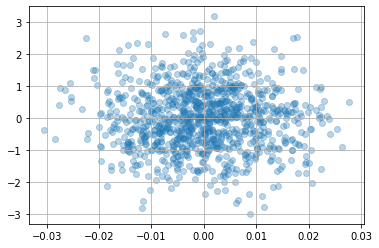

In [8]:
onp.random.seed(0)
samples = onp.random.multivariate_normal(onp.asarray(mu), onp.asarray(sigma), size=1000)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3)
plt.grid()

In [9]:
def log_density_fn(params):
    assert params.shape == mu.shape, "Shape error"
    diff = params - mu

    k = mu.size

    log_density = -jnp.log(2 * jnp.pi) * k / 2
    log_density -= jnp.log(sigma_det) / 2
    log_density -= diff.T @ sigma_inv @ diff / 2
    return log_density

In [30]:
def log_likelihood_fn(_, params, *args, **kwargs):
    return log_density_fn(params), jnp.array(jnp.nan)


def log_prior_fn(_):
    return 0.0


def log_prior_diff_fn(*args):
    return 0.0

In [31]:
fake_net_apply = None
fake_data = jnp.array([[jnp.nan,],]), jnp.array(
    [
        [
            jnp.nan,
        ],
    ]
)
fake_net_state = jnp.array(
    [
        jnp.nan,
    ]
)

# HMC


In [32]:
step_size = 1e-1
trajectory_len = jnp.pi / 2
max_num_leapfrog_steps = int(trajectory_len // step_size + 1)
print("Leapfrog steps per iteration:", max_num_leapfrog_steps)

Leapfrog steps per iteration: 16


In [33]:
update, get_log_prob_and_grad = train_utils.make_hmc_update(
    fake_net_apply, log_likelihood_fn, log_prior_fn, log_prior_diff_fn, max_num_leapfrog_steps, 1.0, 0.0
)

In [34]:
# Initial log-prob and grad values
# params = jnp.ones_like(mu)[None, :]
params = jnp.ones_like(mu)
log_prob, state_grad, log_likelihood, net_state = get_log_prob_and_grad(fake_data, params, fake_net_state)

In [35]:
%%time
num_iterations = 500
all_samples = []
key = jax.random.PRNGKey(0)

for iteration in tqdm.tqdm(range(num_iterations)):

    (params, net_state, log_likelihood, state_grad, step_size, key, accept_prob, accepted) = update(
        fake_data, params, net_state, log_likelihood, state_grad, key, step_size, trajectory_len, True
    )

    if accepted:
        all_samples.append(onp.asarray(params).copy())

#     print("It: {} \t Accept P: {} \t Accepted {} \t Log-likelihood: {}".format(
#             iteration, accept_prob, accepted, log_likelihood))

100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


In [36]:
len(all_samples)

0

In [37]:
log_prob, state_grad, log_likelihood, net_state

(DeviceArray(-4997.733, dtype=float32),
 DeviceArray([-1.e+04, -1.e+00], dtype=float32),
 DeviceArray(-4997.733, dtype=float32),
 ShardedDeviceArray([nan], dtype=float32))

In [38]:
all_samples_cat = onp.stack(all_samples)

ValueError: ignored

In [19]:
plt.scatter(all_samples_cat[:, 0], all_samples_cat[:, 1], alpha=0.3)
plt.grid()

NameError: ignored

# Blackjax

In [1]:
!pip install blackjax

In [2]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

import blackjax.hmc as hmc
import blackjax.nuts as nuts
import blackjax.stan_warmup as stan_warmup

In [3]:
print(jax.devices())

[GpuDevice(id=0, process_index=0)]


In [17]:
potential = lambda x: -log_density_fn(**x)

In [18]:
num_integration_steps = 30
kernel_generator = lambda step_size, inverse_mass_matrix: hmc.kernel(
    potential, step_size, inverse_mass_matrix, num_integration_steps
)

rng_key = jax.random.PRNGKey(0)


initial_position = {"params": np.zeros(2)}
initial_state = hmc.new_state(initial_position, potential)
print(initial_state)

HMCState(position={'params': array([0., 0.])}, potential_energy=DeviceArray(-2.7672932, dtype=float32), potential_energy_grad={'params': DeviceArray([0., 0.], dtype=float32)})


In [20]:
%%time
nsteps = 500
final_state, (step_size, inverse_mass_matrix), info = stan_warmup.run(
    rng_key,
    kernel_generator,
    initial_state,
    nsteps,
)

CPU times: user 3.59 s, sys: 132 ms, total: 3.72 s
Wall time: 2.07 s


In [21]:
%%time
kernel = nuts.kernel(potential, step_size, inverse_mass_matrix)
kernel = jax.jit(kernel)

CPU times: user 1.81 ms, sys: 0 ns, total: 1.81 ms
Wall time: 925 µs


In [22]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [23]:
%%time
nsamples = 500

states = inference_loop(rng_key, kernel, initial_state, nsamples)

samples = states.position["params"].block_until_ready()
print(samples.shape)

(500, 2)
CPU times: user 2.54 s, sys: 69.8 ms, total: 2.61 s
Wall time: 1.72 s


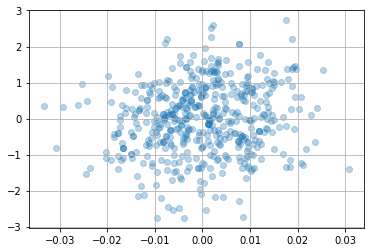

In [24]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3)
plt.grid()